In [1]:
%matplotlib inline


`Learn the Basics <intro.html>`_ ||
`Quickstart <quickstart_tutorial.html>`_ || 
`Tensors <tensorqs_tutorial.html>`_ || 
`Datasets & DataLoaders <data_tutorial.html>`_ ||
`Transforms <transforms_tutorial.html>`_ ||
`Build Model <buildmodel_tutorial.html>`_ ||
**Autograd** ||
`Optimization <optimization_tutorial.html>`_ ||
`Save & Load Model <saveloadrun_tutorial.html>`_

Automatic Differentiation with ``torch.autograd``
=======================================

When training neural networks, the most frequently used algorithm is
**back propagation**. In this algorithm, parameters (model weights) are
adjusted according to the **gradient** of the loss function with respect
to the given parameter.

To compute those gradients, PyTorch has a built-in differentiation engine
called ``torch.autograd``. It supports automatic computation of gradient for any
computational graph.

Consider the simplest one-layer neural network, with input ``x``,
parameters ``w`` and ``b``, and some loss function. It can be defined in
PyTorch in the following manner:



In [2]:
import torch

x = torch.ones(5)  # input tensor
y = torch.zeros(3)  # expected output
print("y: ", y)
w = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3, requires_grad=True)
print("b: ", b)
z = torch.matmul(x, w) + b
print("z: ", z)
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)
print("loss: ", loss)
print("loss.sum(): ", loss.sum())

y:  tensor([0., 0., 0.])
b:  tensor([-0.0988,  0.0603,  0.0086], requires_grad=True)
z:  tensor([-3.1550, -0.2899, -2.3529], grad_fn=<AddBackward0>)
loss:  tensor(0.2304, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
loss.sum():  tensor(0.2304, grad_fn=<SumBackward0>)


Tensors, Functions and Computational graph
------------------------------------------

This code defines the following **computational graph**:

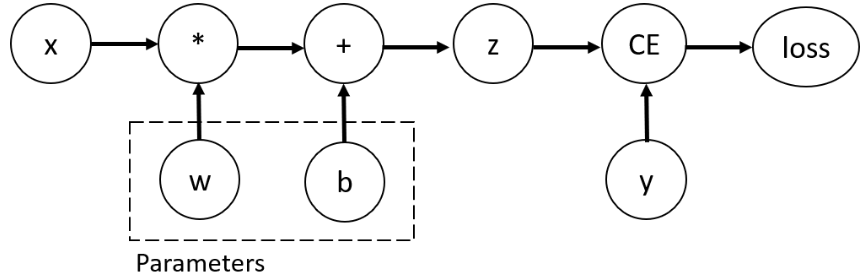

In this network, ``w`` and ``b`` are **parameters**, which we need to
optimize. Thus, we need to be able to compute the gradients of loss
function with respect to those variables. In order to do that, we set
the ``requires_grad`` property of those tensors.



<div class="alert alert-info"><h4>Note</h4><p>You can set the value of ``requires_grad`` when creating a
          tensor, or later by using ``x.requires_grad_(True)`` method.</p></div>



A function that we apply to tensors to construct computational graph is
in fact an object of class ``Function``. This object knows how to
compute the function in the *forward* direction, and also how to compute
its derivative during the *backward propagation* step. A reference to
the backward propagation function is stored in ``grad_fn`` property of a
tensor. You can find more information of ``Function`` `in the
documentation <https://pytorch.org/docs/stable/autograd.html#function>`__.




In [3]:
print('Gradient function for z =', z.grad_fn)
print('Gradient function for loss =', loss.grad_fn)

Gradient function for z = <AddBackward0 object at 0x7f0c0c76f5f8>
Gradient function for loss = <BinaryCrossEntropyWithLogitsBackward object at 0x7f0c0c76fef0>


Computing Gradients
-------------------

To optimize weights of parameters in the neural network, we need to
compute the derivatives of our loss function with respect to parameters,
namely, we need $\frac{\partial loss}{\partial w}$ and
$\frac{\partial loss}{\partial b}$ under some fixed values of
``x`` and ``y``. To compute those derivatives, we call
``loss.backward()``, and then retrieve the values from ``w.grad`` and
``b.grad``:




In [4]:
loss.backward()
print(w.grad)
print(b.grad)
print(b)

tensor([[0.0136, 0.1427, 0.0289],
        [0.0136, 0.1427, 0.0289],
        [0.0136, 0.1427, 0.0289],
        [0.0136, 0.1427, 0.0289],
        [0.0136, 0.1427, 0.0289]])
tensor([0.0136, 0.1427, 0.0289])
tensor([-0.0988,  0.0603,  0.0086], requires_grad=True)


<div class="alert alert-info"><h4>Note</h4><p>- We can only obtain the ``grad`` properties for the leaf
    nodes of the computational graph, which have ``requires_grad`` property
    set to ``True``. For all other nodes in our graph, gradients will not be
    available.
  - We can only perform gradient calculations using
    ``backward`` once on a given graph, for performance reasons. If we need
    to do several ``backward`` calls on the same graph, we need to pass
    ``retain_graph=True`` to the ``backward`` call.</p></div>

Disabling Gradient Tracking
---------------------------

By default, all tensors with ``requires_grad=True`` are tracking their
computational history and support gradient computation. However, there
are some cases when we do not need to do that, for example, when we have
trained the model and just want to apply it to some input data, i.e. we
only want to do *forward* computations through the network. We can stop
tracking computations by surrounding our computation code with
``torch.no_grad()`` block:




In [5]:
z = torch.matmul(x, w)+b
print(z.requires_grad)

with torch.no_grad():
    z = torch.matmul(x, w)+b
print(z.requires_grad)

True
False


Another way to achieve the same result is to use the ``detach()`` method
on the tensor:




In [6]:
z = torch.matmul(x, w)+b
z_det = z.detach()
print(z_det.requires_grad)

False


There are reasons you might want to disable gradient tracking:
  - To mark some parameters in your neural network at **frozen parameters**. This is
    a very common scenario for
    `finetuning a pretrained network <https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html>`__
  - To **speed up computations** when you are only doing forward pass, because computations on tensors that do
    not track gradients would be more efficient.



More on Computational Graphs
----------------------------
Conceptually, autograd keeps a record of data (tensors) and all executed
operations (along with the resulting new tensors) in a directed acyclic
graph (DAG) consisting of
`Function <https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function>`__
objects. In this DAG, leaves are the input tensors, roots are the output
tensors. By tracing this graph from roots to leaves, you can
automatically compute the gradients using the chain rule.

In a forward pass, autograd does two things simultaneously:

- run the requested operation to compute a resulting tensor
- maintain the operation’s *gradient function* in the DAG.

The backward pass kicks off when ``.backward()`` is called on the DAG
root. ``autograd`` then:

- computes the gradients from each ``.grad_fn``,
- accumulates them in the respective tensor’s ``.grad`` attribute
- using the chain rule, propagates all the way to the leaf tensors.

<div class="alert alert-info"><h4>Note</h4><p>**DAGs are dynamic in PyTorch**
  An important thing to note is that the graph is recreated from scratch; after each
  ``.backward()`` call, autograd starts populating a new graph. This is
  exactly what allows you to use control flow statements in your model;
  you can change the shape, size and operations at every iteration if
  needed.</p></div>



Optional Reading: Tensor Gradients and Jacobian Products
--------------------------------------

In many cases, we have a scalar loss function, and we need to compute
the gradient with respect to some parameters. However, there are cases
when the output function is an arbitrary tensor. In this case, PyTorch
allows you to compute so-called **Jacobian product**, and not the actual
gradient.

For a vector function $\vec{y}=f(\vec{x})$, where
$\vec{x}=\langle x_1,\dots,x_n\rangle$ and
$\vec{y}=\langle y_1,\dots,y_m\rangle$, a gradient of
$\vec{y}$ with respect to $\vec{x}$ is given by **Jacobian
matrix**:

\begin{align}J=\left(\begin{array}{ccc}
      \frac{\partial y_{1}}{\partial x_{1}} & \cdots & \frac{\partial y_{1}}{\partial x_{n}}\\
      \vdots & \ddots & \vdots\\
      \frac{\partial y_{m}}{\partial x_{1}} & \cdots & \frac{\partial y_{m}}{\partial x_{n}}
      \end{array}\right)\end{align}

Instead of computing the Jacobian matrix itself, PyTorch allows you to
compute **Jacobian Product** $v^T\cdot J$ for a given input vector
$v=(v_1 \dots v_m)$. This is achieved by calling ``backward`` with
$v$ as an argument. The size of $v$ should be the same as
the size of the original tensor, with respect to which we want to
compute the product:




In [7]:
inp = torch.eye(5, requires_grad=True)
print("inp: ", inp)
print("inp.grad: ", inp.grad)
out = (inp+1).pow(2)
print("out: ", out)
out.backward(gradient=torch.ones_like(inp), retain_graph=True)  # gradient=torch.ones_like(inp)
print("First call\n", inp.grad)
out.backward(torch.ones_like(inp), retain_graph=True)
print("\nSecond call\n", inp.grad)
inp.grad.zero_()
print("inp.grad: ", inp.grad)
out.backward(torch.ones_like(inp), retain_graph=True)
print("\nCall after zeroing gradients\n", inp.grad)

inp:  tensor([[1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.]], requires_grad=True)
inp.grad:  None
out:  tensor([[4., 1., 1., 1., 1.],
        [1., 4., 1., 1., 1.],
        [1., 1., 4., 1., 1.],
        [1., 1., 1., 4., 1.],
        [1., 1., 1., 1., 4.]], grad_fn=<PowBackward0>)
First call
 tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.],
        [2., 2., 2., 2., 4.]])

Second call
 tensor([[8., 4., 4., 4., 4.],
        [4., 8., 4., 4., 4.],
        [4., 4., 8., 4., 4.],
        [4., 4., 4., 8., 4.],
        [4., 4., 4., 4., 8.]])
inp.grad:  tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

Call after zeroing gradients
 tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2.

Notice that when we call ``backward`` for the second time with the same
argument, the value of the gradient is different. This happens because
when doing ``backward`` propagation, PyTorch **accumulates the
gradients**, i.e. the value of computed gradients is added to the
``grad`` property of all leaf nodes of computational graph. If you want
to compute the proper gradients, you need to zero out the ``grad``
property before. In real-life training an *optimizer* helps us to do
this.



<div class="alert alert-info"><h4>Note</h4><p>Previously we were calling ``backward()`` function without
          parameters. This is essentially equivalent to calling
          ``backward(torch.tensor(1.0))``, which is a useful way to compute the
          gradients in case of a scalar-valued function, such as loss during
          neural network training.</p></div>




Further Reading
~~~~~~~~~~~~~~~~~
- `Autograd Mechanics <https://pytorch.org/docs/stable/notes/autograd.html>`_

